In [16]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_USER_POSTS = PATH_DATA + 'user_posts/'

PATH_RESULTS = os.environ.get('PATH_OPENSKY') + 'results/'
PATH_USER_REPLIES_NEWS_POSTS = PATH_RESULTS + 'agg_user_replies_news_posts_2.csv'
PATH_ALL_SENTIMENTS = os.environ.get('PATH_OPENSKY') + 'results/all_sentiments_over_time.csv'

COLOR_POSITIVE = os.environ.get('COLOR_POSITIVE')
COLOR_NEUTRAL = os.environ.get('COLOR_NEUTRAL')
COLOR_NEGATIVE = os.environ.get('COLOR_NEGATIVE')


In [17]:
df_news_posts = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)
bm_first_depth = (df_news_posts.reply_to == df_news_posts.thread_root)
df_news_posts = df_news_posts[bm_first_depth]
df_news_posts.dropna(subset=['sent_label'], inplace=True)
df_news_posts['date'] = pd.to_datetime(df_news_posts['date'], errors='coerce')

sent_label_mapping = { 0: 'negative', 1: 'neutral', 2: 'positive'}
df_news_posts.loc[:, 'sent_label'] = df_news_posts.sent_label.map(sent_label_mapping)
df_news_posts

/tmp/ipykernel_12964/4123129271.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news_posts = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)
/tmp/ipykernel_12964/4123129271.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['positive' 'positive' 'neutral' ... 'negative' 'negative' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_news_posts.loc[:, 'sent_label'] = df_news_posts.sent_label.map(sent_label_mapping)


,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
0,10657080,284413,bsky.social,2024-01-14 08:03:00,let’s hope his expands ten fold 💪💪,['eng'],0,0,0,10657081.0,15717.0,10657081.0,15717.0,NaN,NaN,NaN,NaN,NaN,positive,0.945
1,10657084,284413,bsky.social,2024-01-12 22:12:00,"yes, we can do this! 💪",['eng'],3,0,0,5595208.0,2486.0,5595208.0,2486.0,NaN,NaN,NaN,NaN,NaN,positive,0.956
2,10657085,284413,bsky.social,2024-01-11 14:19:00,"in other words, “as long as it takes” it refer...",['eng'],0,1,0,10657086.0,12030.0,10657086.0,12030.0,NaN,NaN,NaN,NaN,NaN,neutral,0.583
3,10657096,284413,bsky.social,2024-01-08 14:10:00,i’ll believe it when i see the weapons in Ukra...,['eng'],0,0,0,10657097.0,15717.0,10657097.0,15717.0,NaN,NaN,NaN,NaN,NaN,neutral,0.509
4,10657117,284413,bsky.social,2024-01-05 09:22:00,Expect the world to become way way worse. If a...,['eng'],1,0,0,5271912.0,15717.0,5271912.0,15717.0,NaN,NaN,NaN,NaN,NaN,negative,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36812,110584107,527683,bsky.social,2023-10-06 20:06:00,Are you kidding?\n\nThere are always people wh...,['eng'],3,1,0,4108566.0,379.0,4108566.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.929
36817,105014318,92560,bsky.social,2024-03-08 01:59:00,What a complete abdication of good journalism ...,['eng'],0,0,0,698597.0,9.0,698597.0,9.0,NaN,NaN,NaN,NaN,NaN,negative,0.790
36818,105014322,92560,bsky.social,2024-03-07 22:16:00,Trump and Biden are at par with age...exactly ...,['eng'],4,0,0,127576.0,379.0,127576.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.867
36819,105014501,92560,bsky.social,2024-01-05 08:08:00,Because doctors are literally refusing to pres...,['eng'],1,0,0,145919.0,379.0,145919.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.882


In [18]:
df_all_replies = pd.read_csv(PATH_ALL_SENTIMENTS, index_col=0)
df_all_replies.loc[:, 'sent_label'] = df_all_replies.sent_label.map(sent_label_mapping)
df_all_replies['date'] = pd.to_datetime(df_all_replies['date'], errors='coerce')

# Removing all posts present in the news feed replies df
bm_not_in_news_feed = ~df_all_replies.post_id.isin(df_news_posts.post_id)
df_all_replies = df_all_replies[bm_not_in_news_feed]

df_all_replies

/tmp/ipykernel_12964/1780271783.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['negative' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_all_replies.loc[:, 'sent_label'] = df_all_replies.sent_label.map(sent_label_mapping)


,post_id,user_id,date,labels,sent_label,sent_score,reply_to,thread_root
9,79798842,527934,2024-03-18 01:33:00,NaN,negative,0.939,79798843.0,79798843.0
34,79798860,527934,2024-03-16 21:16:00,NaN,neutral,0.757,51667361.0,51667361.0
40,79798869,527934,2024-03-16 04:31:00,NaN,negative,0.791,79798870.0,79798870.0
42,79798871,527934,2024-03-16 02:37:00,NaN,positive,0.985,79798872.0,79798872.0
80,79798908,527934,2024-03-13 20:05:00,NaN,negative,0.930,79798838.0,79798838.0
...,...,...,...,...,...,...,...,...
21,1314169,3401925,2024-02-23 15:38:00,NaN,neutral,0.630,1314170.0,1314170.0
33,1314182,3401925,2024-02-13 04:12:00,NaN,neutral,0.634,1314183.0,1314183.0
40,1314189,3401925,2024-02-08 22:14:00,NaN,positive,0.978,1314190.0,1314190.0
44,1314193,3401925,2024-02-07 08:33:00,NaN,positive,0.844,1314194.0,1314194.0


In [19]:
reply_counts = df_all_replies.groupby('reply_to').size().sort_values(ascending=False).reset_index(name='count')

# Calculate the cumulative sum
cumulative_replies = reply_counts['count'].cumsum()
cumulative_replies = cumulative_replies / cumulative_replies.max()
origin = pd.Series([0])
cumulative_replies = pd.concat([origin, cumulative_replies]).reset_index(drop=True)

In [20]:
cumulative_replies.reset_index(drop=True)[1e6]

np.float64(0.4724938699673922)

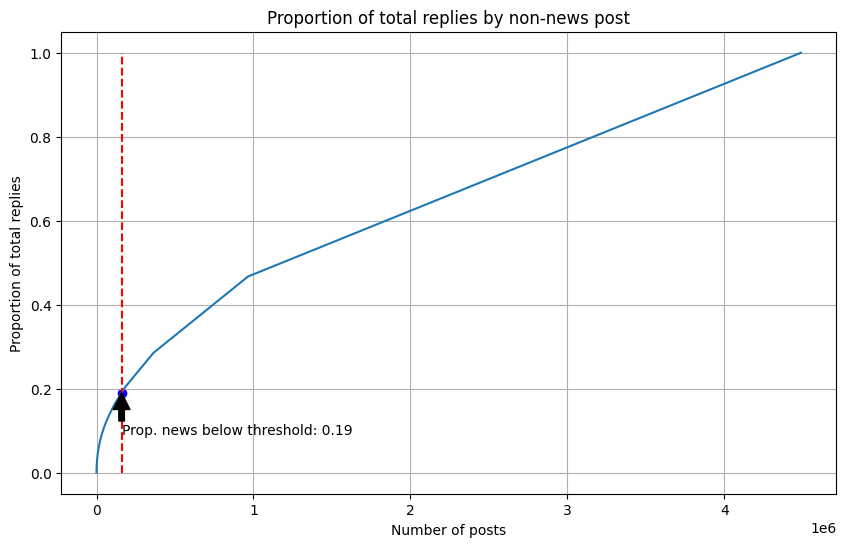

In [21]:
# Plot the cumulative sum
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cumulative_replies)
ax.set_xlabel('Number of posts')
ax.set_ylabel('Proportion of total replies')
ax.set_title('Proportion of total replies by non-news post')

news_reply_threshold = 160000
ax.vlines(news_reply_threshold, 0, 1, color='red', linestyle='--')

intersection_y = cumulative_replies.iloc[news_reply_threshold] if news_reply_threshold < len(cumulative_replies) else 1
ax.scatter(news_reply_threshold, intersection_y, color='blue')
ax.annotate(f'Prop. news below threshold: {intersection_y:.2f}', 
            xy=(news_reply_threshold, intersection_y), 
            xytext=(news_reply_threshold + 50, intersection_y - 0.1),
            arrowprops=dict(facecolor='black', shrink=1))

ax.grid(True)

In [22]:
reply_counts.iloc[news_reply_threshold]

reply_to    5559711.0
count             4.0
Name: 160000, dtype: float64

In [23]:
relevant_news_posts = reply_counts.head(news_reply_threshold).reply_to.values
df_all_replies = df_all_replies[df_all_replies.reply_to.isin(relevant_news_posts)]
df_all_replies

,post_id,user_id,date,labels,sent_label,sent_score,reply_to,thread_root
532,79799347,527934,2024-02-13 16:55:00,NaN,neutral,0.928,6369073.0,6369073.0
649,79799462,527934,2024-02-04 03:41:00,NaN,neutral,0.658,1960204.0,1960204.0
1783,79800556,527934,2023-10-28 18:56:00,NaN,neutral,0.625,160257.0,160257.0
294,38539170,317609,2024-03-04 10:02:00,NaN,positive,0.984,38539124.0,38539124.0
600,38539863,317609,2024-02-18 12:01:00,NaN,positive,0.985,187711.0,187711.0
...,...,...,...,...,...,...,...,...
9,52363056,1057073,2023-10-23 15:23:00,NaN,negative,0.865,13271140.0,13271140.0
21,52363070,1057073,2023-08-24 03:50:00,NaN,neutral,0.680,18602800.0,18602800.0
1,68998727,1848807,2023-10-17 07:28:00,NaN,positive,0.977,2175936.0,2175936.0
1,177173027,3283530,2024-03-09 03:30:00,NaN,negative,0.884,65862.0,65862.0


In [24]:
num_sent_replies = df_all_replies.groupby(['reply_to', 'sent_label']).size().unstack()

normalized_df = num_sent_replies.apply(lambda x: x / x.sum(), axis=1)
normalized_df

sent_label,negative,neutral,positive
reply_to,,,
14.0,NaN,NaN,1.000000
47.0,NaN,0.548387,0.451613
50.0,0.250000,0.666667,0.083333
94.0,0.010526,0.147368,0.842105
218.0,0.666667,NaN,0.333333
...,...,...,...
231706627.0,0.200000,NaN,0.800000
232821318.0,NaN,0.727273,0.272727
232847215.0,0.857143,0.142857,NaN


In [25]:
normalized_df = normalized_df.sort_values(by='negative', ascending=False)
normalized_df.replace(np.nan, 0, inplace=True)
normalized_df

sent_label,negative,neutral,positive
reply_to,,,
1386000.0,1.0,0.000000,0.000000
10695859.0,1.0,0.000000,0.000000
10697032.0,1.0,0.000000,0.000000
10696813.0,1.0,0.000000,0.000000
3995467.0,1.0,0.000000,0.000000
...,...,...,...
229157112.0,0.0,1.000000,0.000000
229629553.0,0.0,0.230769,0.769231
230583313.0,0.0,1.000000,0.000000


In [34]:
color_map = {
    'positive': COLOR_POSITIVE,
    'neutral': COLOR_NEUTRAL,
    'negative': COLOR_NEGATIVE
}

In [26]:
#normalized_df.loc[:, 'neut_plus_pos'] = normalized_df['neutral'] + normalized_df['positive']
#normalized_df.drop(columns=['neutral', 'positive'], inplace=True)
normalized_df

sent_label,negative,neutral,positive
reply_to,,,
1386000.0,1.0,0.000000,0.000000
10695859.0,1.0,0.000000,0.000000
10697032.0,1.0,0.000000,0.000000
10696813.0,1.0,0.000000,0.000000
3995467.0,1.0,0.000000,0.000000
...,...,...,...
229157112.0,0.0,1.000000,0.000000
229629553.0,0.0,0.230769,0.769231
230583313.0,0.0,1.000000,0.000000


In [46]:
normalized_df.reset_index(inplace=True, drop=True)
subset_normalized_df = normalized_df.iloc[::10]

In [47]:
subset_normalized_df

sent_label,negative,neutral,positive
0,1.0,0.000000,0.000000
10,1.0,0.000000,0.000000
20,1.0,0.000000,0.000000
30,1.0,0.000000,0.000000
40,1.0,0.000000,0.000000
...,...,...,...
159950,0.0,0.500000,0.500000
159960,0.0,0.250000,0.750000
159970,0.0,1.000000,0.000000
159980,0.0,0.105263,0.894737


In [48]:
subset_normalized_df

sent_label,negative,neutral,positive
0,1.0,0.000000,0.000000
10,1.0,0.000000,0.000000
20,1.0,0.000000,0.000000
30,1.0,0.000000,0.000000
40,1.0,0.000000,0.000000
...,...,...,...
159950,0.0,0.500000,0.500000
159960,0.0,0.250000,0.750000
159970,0.0,1.000000,0.000000
159980,0.0,0.105263,0.894737


[Text(0, 0, '0'),
 Text(1000, 0, '10000'),
 Text(2000, 0, '20000'),
 Text(3000, 0, '30000'),
 Text(4000, 0, '40000'),
 Text(5000, 0, '50000'),
 Text(6000, 0, '60000'),
 Text(7000, 0, '70000'),
 Text(8000, 0, '80000'),
 Text(9000, 0, '90000'),
 Text(10000, 0, '100000'),
 Text(11000, 0, '110000'),
 Text(12000, 0, '120000'),
 Text(13000, 0, '130000'),
 Text(14000, 0, '140000'),
 Text(15000, 0, '150000')]

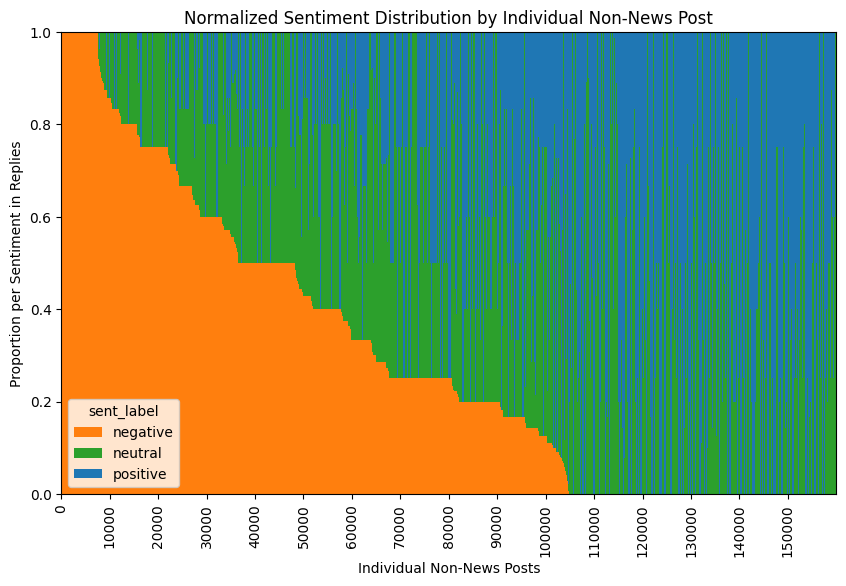

In [51]:
ax = subset_normalized_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=1, edgecolor=None, color=[color_map[col] for col in subset_normalized_df.columns])
ax.set_xlabel('Individual Non-News Posts')
ax.set_ylabel('Proportion per Sentiment in Replies')
ax.set_title('Normalized Sentiment Distribution by Individual Non-News Post')

ax.set_ylim(0, 1)

# Set xticks to the original indices of the sampled rows
xticks = range(0, len(subset_normalized_df), 1000)
ax.set_xticks(xticks)
ax.set_xticklabels(subset_normalized_df.index[::1000])